#Custom Apriltag image classifier
Author: Sania Zahan Date: 17/11/2025

#Organize Your Dataset:
Create a main directory for your dataset. Inside this main directory, create subdirectories, where each subdirectory represents a class, and contains the images belonging to that class.

Apriltag images: https://github.com/AprilRobotics/apriltag-imgs

Tags and corresponding labels:

tag16h5 -> Left; tag25h9 -> Right;

tag36h11 -> Forward; tagCircle21h7 -> Backward

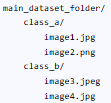

#Download and unzip data
Dataset link:

In [3]:
!unzip apriltag_dataset.zip

Archive:  apriltag_dataset.zip
   creating: apriltag_dataset/
   creating: apriltag_dataset/backward/
  inflating: apriltag_dataset/backward/alltags.ps  
  inflating: apriltag_dataset/backward/mosaic.png  
  inflating: apriltag_dataset/backward/tag21_07_00000.png  
  inflating: apriltag_dataset/backward/tag21_07_00001.png  
  inflating: apriltag_dataset/backward/tag21_07_00002.png  
  inflating: apriltag_dataset/backward/tag21_07_00003.png  
  inflating: apriltag_dataset/backward/tag21_07_00004.png  
  inflating: apriltag_dataset/backward/tag21_07_00005.png  
  inflating: apriltag_dataset/backward/tag21_07_00006.png  
  inflating: apriltag_dataset/backward/tag21_07_00007.png  
  inflating: apriltag_dataset/backward/tag21_07_00008.png  
  inflating: apriltag_dataset/backward/tag21_07_00009.png  
  inflating: apriltag_dataset/backward/tag21_07_00010.png  
  inflating: apriltag_dataset/backward/tag21_07_00011.png  
  inflating: apriltag_dataset/backward/tag21_07_00012.png  
  inflating: a

#Import necessary libraries

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

#Load the Dataset with image_dataset_from_directory:

Keras's image_dataset_from_directory utility is designed for this purpose.

In [4]:
# Define parameters for loading the dataset
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
    'apriltag_dataset', # Path to your main dataset folder
    labels='inferred',
    label_mode='int', # 'int' for integer-encoded labels (0, 1, 2...), 'binary' for 0/1, 'categorical' for one-hot
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.2, # Optional: split a portion for validation
    subset='training',
    seed=123 # For reproducible split
)

# Load the validation data (if validation_split was used)
val_ds = tf.keras.utils.image_dataset_from_directory(
    'apriltag_dataset',
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle validation data
    validation_split=0.2,
    subset='validation',
    seed=123
)

# Get class names
class_names = train_ds.class_names
print(f"Class names: {class_names}")

Found 694 files belonging to 4 classes.
Using 556 files for training.
Found 694 files belonging to 4 classes.
Using 138 files for validation.
Class names: ['backward', 'forward', 'left', 'right']


#Prepare the Data for Training:
Optimize performance by prefetching and caching.

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#Build and Train Your Model:
Define a Convolutional Neural Network (CNN) and train it.

In [6]:
num_classes = len(class_names)

model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax') # Use 'softmax' for multi-class classification
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # from_logits=False if using softmax
              metrics=['accuracy'])

model.summary()

epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,121,380 (8.09 MB)

 Trainable params: 2,121,380 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 584ms/step - accuracy: 0.7668 - loss: 0.6228 - val_accuracy: 0.9928 - val_loss: 0.1156
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 516ms/step - accuracy: 0.9982 - loss: 0.0247 - val_accuracy: 1.0000 - val_loss: 0.0092
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 502ms/step - accuracy: 0.9994 - loss: 0.0059 - val_accuracy: 0.9928 - val_loss: 0.0164
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 552ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 0.0061
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 568ms/step - accuracy: 1.0000 - loss: 5.6506e-04 - val_accuracy: 1.0000 - val_loss: 0.0015
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 529ms/step - accuracy: 1.0000 - loss: 1.1218e-04 - val_accuracy: 1.0000 - val_loss: 4.7205e-04
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 502ms/step - accuracy: 1.0000 - loss: 5.8976e-05 - val_accuracy: 1.0000 - val_loss: 2.8482e-04
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 557ms/step - accuracy: 1.0000 - loss: 4

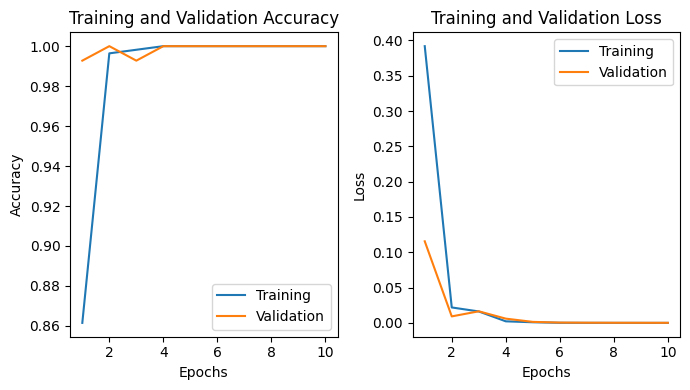

In [17]:
# Get the history data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(7, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate and Predict:
Evaluate the model's performance and make predictions on new images.

In [21]:
# Evaluate the model
loss, accuracy = model.evaluate(val_ds)
print(f"Validation accuracy: {accuracy}")

# Example prediction on a single image (replace with your image path)
image_path = './apriltag_dataset/backward/tag21_07_00000.png'
img = tf.keras.utils.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(f"This image most likely belongs to {class_names[tf.argmax(score)]} with a {100 * tf.reduce_max(score):.2f}% confidence.")

# Example prediction on a single image (replace with your image path)
image_path = './apriltag_dataset/left/tag16_05_00011.png'
img = tf.keras.utils.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(f"This image most likely belongs to {class_names[tf.argmax(score)]} with a {100 * tf.reduce_max(score):.2f}% confidence.")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - accuracy: 1.0000 - loss: 8.3954e-05
Validation accuracy: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
This image most likely belongs to backward with a 47.54% confidence.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
This image most likely belongs to left with a 47.54% confidence.
